## Python script to collect the last 30 days of temperature data from a web API for select cities in the US - Python 3 Version

The goal of the following code is to collect observed weather data from The Dark Sky Forecast API (https://developer.forecast.io/docs/v2#time_cal), extract the maximum daily temperatures for the last 30 days for select cities, store the extracted data in a SQLite database, perform summary calculations, visualize the results and write them to a .csv file.

This version uses Python 3.  dataframe.iteritems and dataframe.set_value have been replaced with dataframe.items and dataframe.at respectively since the former two have been deprecated in Python 3.

Start by importing the necessary Python libraries.

In [1]:
%matplotlib inline
import datetime
import requests
import json
import sqlite3 as lite
import pandas as pd
import seaborn as sns

Create cities dictionary to include cities of interest and their locations.

In [2]:
cities = {"Atlanta": '33.755960,-84.390304',
          "Austin": '30.265327,-97.743788',
          "Boston": '42.358056,-71.063611',
          "Denver": '39.761850,-104.881105',
          "Los Angeles": '34.050000,-118.250000',
          "Seattle": '47.609722,-122.333056'
          }

Initialize a few key variables.  The start date is 30 days before now; "num_days" holds this 30-day value.

In [3]:
num_days = 30
start_date = datetime.datetime.now() - datetime.timedelta(days=num_days)
APIKEY = "2afe41b558da0181d1a9483c41f42df8"

Create a connection object, "con", which is the connection to the SQLite database "weather.db". (If weather.db does not exist, SQLite3 will create it.)
Once the connection object "con" has been created, use the .cursor method to create a cursor object, "cur", to manipulate tables in the "weather.db" database.
If the "temperature" table exists in the "weather.db" database, drop it and create a new table to start fresh with an empty table.

In [4]:
con = lite.connect('weather.db')
with con:
    cur = con.cursor()
    cur.execute("DROP TABLE IF EXISTS temperature")
    cur.execute("CREATE TABLE temperature \
    (city text, tmax float, tmax_time integer)")

Next loop through all the cities in the "cities" dictionary, creating a properly formatted API request for that city for each day of data desired (30 days in this example).  Once the API request has been formatted, ping the API to get the data, select the data of interest (which is the maximum temperature for that day in this example) and store it in the "weather.db" database as well as a Pandas DataFrame, "df", to aid in future calculations.
This process requires a loop within a loop.  The inner loop collects the data for a single city for each day of the period of interest, the past 30 days in this case.  The outer loop cycles through each of the cities. 

In [5]:
for city_var, latLong in cities.items():
    
    date = start_date     # initialize the date variable
    
    for i in range(0, num_days):  
        date_str = (date.strftime('%Y') + '-' + date.strftime('%m') + '-' +
                    date.strftime('%d') + 'T' + date.strftime('%H') + ':' +
                    date.strftime('%M') + ':' + date.strftime('%S'))

        url = ('https://api.forecast.io/forecast/' + APIKEY + '/' + latLong +
               ',' + date_str)

        r = requests.get(url)  # issue the request
        response_dict = json.loads(r.text)

        tmax_var = response_dict['daily']['data'][0]['temperatureMax']
        tmax_time_var = response_dict['daily']['data'][0]['temperatureMaxTime']
        
        # convert time of max temperature from UNIX time to standard format
        tmax_time_var_std = (datetime.datetime.fromtimestamp
                             (int(tmax_time_var))
                             .strftime('%Y-%m-%d %H:%M:%S'))

        con = lite.connect('weather.db')
        with con:
            cur = con.cursor()
            cur.execute("INSERT INTO temperature (city, tmax, tmax_time) \
            VALUES (?, ?, ?)", (city_var, tmax_var, tmax_time_var_std))
            cur.execute("SELECT * FROM temperature")

            # store all rows of data in the "rows" variable
            rows = cur.fetchall()
            
            # get the column names from the cur.description attribute 
            # which are in the first position, the 0th spot.
            cols = [desc[0] for desc in cur.description] 
            
            df = pd.DataFrame(rows, columns=cols)

        date = date + datetime.timedelta(days=1)

Let's look at the first and last five rows of the data in the "df" DataFrame.  Each row is one day's worth of data; "tmax" is the maximum temperature for the day in degrees Fahrenheit; "tmax_time" is the date and time of the maximum temperature that day.

In [6]:
df.head()

,city,tmax,tmax_time
0,Atlanta,90.47,2018-08-05 13:00:00
1,Atlanta,92.41,2018-08-06 14:00:00
2,Atlanta,90.17,2018-08-07 12:00:00
3,Atlanta,90.85,2018-08-08 13:00:00
4,Atlanta,87.11,2018-08-09 10:00:00


In [7]:
df.tail()

,city,tmax,tmax_time
175,Seattle,72.16,2018-08-30 17:00:00
176,Seattle,68.18,2018-08-31 17:00:00
177,Seattle,70.26,2018-09-01 16:00:00
178,Seattle,73.89,2018-09-02 16:00:00
179,Seattle,72.18,2018-09-03 17:00:00


Calculate summary statistics over the 30-day period and store in a new DataFrame, "df_summary"; separate the latitude and longitude into two columns instead of one, converting them from strings to floats; then write the DataFrame to a .csv file called "summary.csv".

In [10]:
df_summary = pd.DataFrame(columns=('city', 'long', 'lat', 'max_tmax',
                                   'min_tmax', 'range_tmax', 'mean_tmax',
                                   'sd_tmax'))

df_summary['max_tmax'] = df.groupby('city')['tmax'].max()
df_summary['min_tmax'] = df.groupby('city')['tmax'].min()
df_summary['mean_tmax'] = df.groupby('city')['tmax'].mean()
df_summary['sd_tmax'] = df.groupby('city')['tmax'].std()
df_summary['range_tmax'] = df_summary['max_tmax'] - df_summary['min_tmax']
df_summary['city'] = df_summary.index

for k, v in cities.items():
    location = tuple(float(x) for x in v.split(','))
    #df_summary.set_value(k,'lat',location[0])
    #df_summary.set_value(k,'long',location[1])
    #df.at[index, col] = val
    df_summary.at[k,'lat'] = location[0]
    df_summary.at[k,'long'] = location[1]
    
df_summary.to_csv('summary.csv', index=False)

Let's look at the "df_summary" DataFrame. Since there are only six cities, we can look at all of the rows, not just the first five.

In [11]:
df_summary

,city,long,lat,max_tmax,min_tmax,range_tmax,mean_tmax,sd_tmax
city,,,,,,,,
Atlanta,Atlanta,-84.3903,33.756,92.41,81.11,11.30,87.496333,2.716873
Austin,Austin,-97.7438,30.2653,100.88,86.45,14.43,97.098000,3.301244
Boston,Boston,-71.0636,42.3581,95.41,71.19,24.22,83.162000,7.620656
Denver,Denver,-104.881,39.7619,90.80,70.21,20.59,83.829000,5.782718
Los Angeles,Los Angeles,-118.25,34.05,97.24,79.81,17.43,86.669667,4.714069
Seattle,Seattle,-122.333,47.6097,91.30,63.00,28.30,76.955333,7.563708


Create a box plot for each city using the seaborn library.

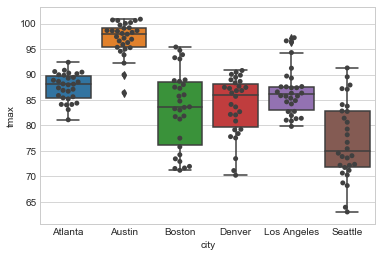

In [12]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="city", y="tmax", data=df.sort_values(by='city'))
ax = sns.swarmplot(x="city", y="tmax", data=df.sort_values(by='city'),
                   color=".25")

If you have not run the code above yourself, it should show data from the 30 days between August 5, 2018 and September 3, 2018 inclusive.  

For this time period, the data show that the maximum daily temperature for Atlanta has the smallest fluctuation changing only 11.30 degrees over the 30-days compared to Seattle, which has the largest range of 28.30 degrees F.  

Seattle also has the lowest mean maximum daily temperature of the six cities considered at 76.96 degrees F.

Austin has the highest mean maximum temperature over the period, by 10 degrees F.  The box plot shows quite clearly that it is just plain hot there compared to the other cities.  This statement was true in June 2016 when I created the Python 2 example, and it is still true in August 2018.